# Credit Card fraud detection - Using Autoencoders

#### Deep learning tries to look at the problem of credit card fraud and anomalie detection by training the network on non-fraudulent transactions, resulting in a low MSE or in the case of Auto encoders low reconstruction error. This causes fraudulent transactions to be detected by flagging them based on higher than normal MSE values.

Refrence to Medium.com (Venelin Valkov) for Credit Card fraud detection using Autoencoders and his ideas, which has helped with some of the ideas used in this notebook
https://medium.com/@curiousily/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras


In [1]:
import pandas as pd
import numpy as np
import keras as ke
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


#### Loading the data

We used the Kaggle dataset on Credit card fraud ref:[Kaggle](https://www.kaggle.com/dalpozz/creditcardfraud). 
It contains data about credit card transactions from European credit card holders that occurred during a period of two days in Sep 2013, with 492 frauds out of 284,807 transactions. The frauds account for 0.172% of the total transactions.

Kaggle describes the data to have 30 features that are numberical values from a transformed dataset using PCA transformation(s) in a reduced feature dimension space due to privacy reasons. 

The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.

Label 'Class' is the target class lable with 1 representing the fraud case and 0 representing the normal case

In [2]:
df = pd.read_csv("creditcard.csv")

# Exploration

In [3]:
df.shape

(284807, 31)

In [4]:
df.isnull().values.any()

False

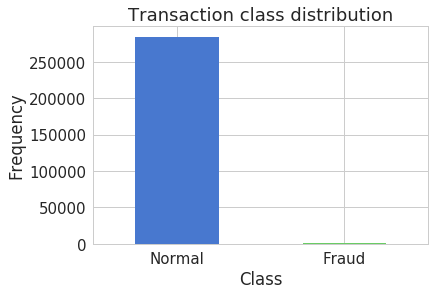

In [5]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

#### Looking at data imbalance 
We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [6]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [7]:
frauds.shape

(492, 31)

In [8]:
normal.shape

(284315, 31)

#### How different are the amount of money used in different transaction classes?

In [9]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [10]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

####  Let's have a more graphical representation:

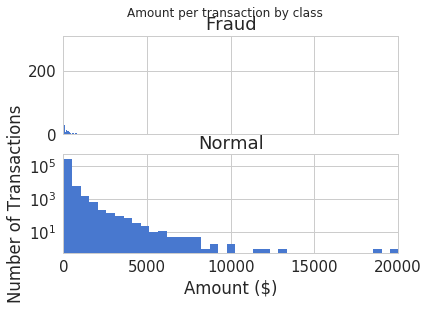

In [11]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

### Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. 
Standardizing the data is required for the Autoencoder to work effectively and converge as with most Neural Network architechtures. Data is normally distributed using scaling to remove the mean and scales the values to unit variance. The sklearn StandarScaler does this:

In [12]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

### Step critical to our Autoencoder to help solve this problem
Training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:

In [13]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [14]:
X_train.shape

(227451, 29)

In [15]:
input_dim = X_train.shape[1]
encoding_dim = 14

### Autoencoder in Keras with unbalanced dataset

Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively.  The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:

In [16]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

### Training the model

Let's train our model for 50 epochs with a batch size of 32 samples and learning rate of 0.01

In [17]:
nb_epoch = 50
batch_size = 32

#learning rate = 0.01
autoencoder.compile(optimizer=ke.optimizers.Adam(lr=1e-2), 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/50
227451/227451 [==============================] - 27s 117us/step - loss: 0.8396 - acc: 0.4509 - val_loss: 0.8504 - val_acc: 0.4878
Epoch 2/50
227451/227451 [==============================] - 26s 114us/step - loss: 0.8204 - acc: 0.4826 - val_loss: 0.8502 - val_acc: 0.4857
Epoch 3/50
227451/227451 [==============================] - 26s 114us/step - loss: 0.8204 - acc: 0.4820 - val_loss: 0.8430 - val_acc: 0.4817
Epoch 4/50
227451/227451 [==============================] - 26s 114us/step - loss: 0.8199 - acc: 0.4814 - val_loss: 0.8460 - val_acc: 0.4864
Epoch 5/50
227451/227451 [==============================] - 26s 113us/step - loss: 0.8205 - acc: 0.4801 - val_loss: 0.8440 - val_acc: 0.4906
Epoch 6/50
227451/227451 [==============================] - 26s 113us/step - loss: 0.8188 - acc: 0.4816 - val_loss: 0.8419 - val_acc: 0.4834
Epoch 7/50
227451/227451 [==============================] - 26s 113us/step - loss: 0.8182 - acc: 0.4817

In [22]:
autoencoder = load_model('model.h5')

### Evaluation

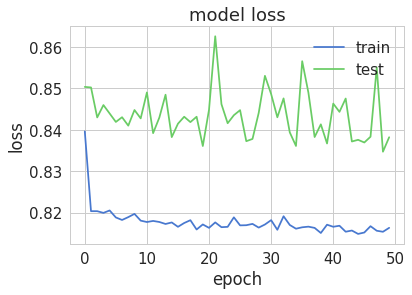

In [23]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

### Training the model

Let's train our model for 50 epochs with a batch size of 16 samples and learning rate of 0.0001

In [24]:
nb_epoch = 50
batch_size = 16
#change learning rate to 0.0001 
autoencoder.compile(optimizer=ke.optimizers.Adam(lr=1e-4), 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h6",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/50
227451/227451 [==============================] - 51s 226us/step - loss: 0.7862 - acc: 0.5125 - val_loss: 0.8119 - val_acc: 0.5199
Epoch 2/50
227451/227451 [==============================] - 51s 226us/step - loss: 0.7830 - acc: 0.5180 - val_loss: 0.8101 - val_acc: 0.5222
Epoch 3/50
227451/227451 [==============================] - 51s 226us/step - loss: 0.7816 - acc: 0.5203 - val_loss: 0.8092 - val_acc: 0.5239
Epoch 4/50
227451/227451 [==============================] - 51s 226us/step - loss: 0.7807 - acc: 0.5217 - val_loss: 0.8085 - val_acc: 0.5241
Epoch 5/50
227451/227451 [==============================] - 51s 225us/step - loss: 0.7800 - acc: 0.5221 - val_loss: 0.8079 - val_acc: 0.5238
Epoch 6/50
227451/227451 [==============================] - 51s 225us/step - loss: 0.7794 - acc: 0.5230 - val_loss: 0.8076 - val_acc: 0.5275
Epoch 7/50
227451/227451 [==============================] - 51s 226us/step - loss: 0.7790 - acc: 0.5238

In [25]:
autoencoder = load_model('model.h6')

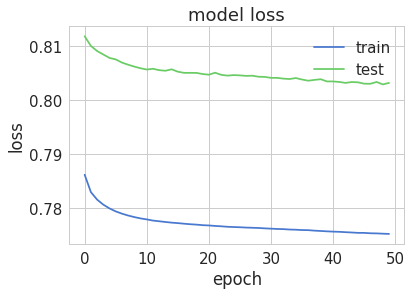

In [26]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [19]:
predictions = autoencoder.predict(X_test)

In [20]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [25]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.736786,0.001720
std,3.425248,0.041443
min,0.040684,0.000000
25%,0.241022,0.000000
50%,0.399110,0.000000
75%,0.635176,0.000000
max,264.437441,1.000000


### Reconstruction error without fraud and compare with injecting fradulent transactions

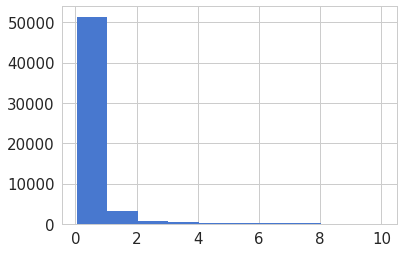

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

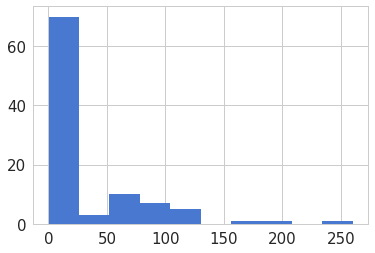

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [30]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

### ROC Curve
ROC curves are very useful tool for understanding the performance of binary classifiers when compared to a Confusion Matrix

Also our ROC Curve has a high AUC score showing this is a strong model

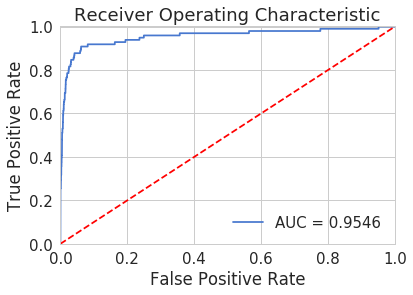

In [31]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

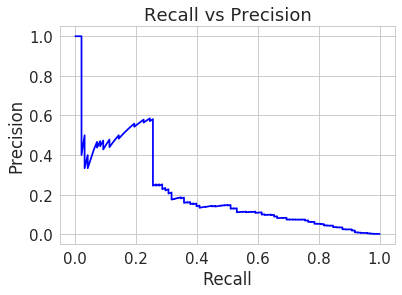

In [32]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

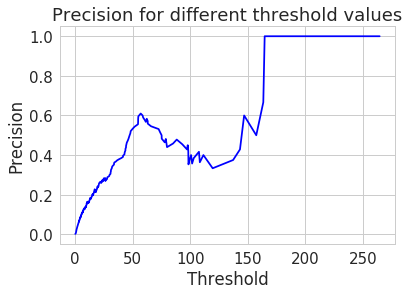

In [31]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

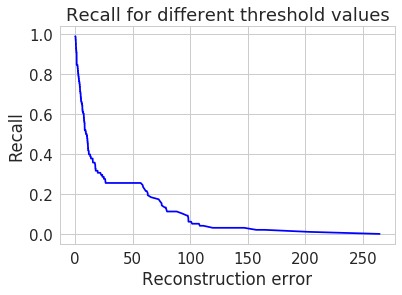

In [32]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

# Prediction

Prediction using a threshold value is a subjective approach depending on what one thinks an ideal threshold value would be. We have provided examples of this in our paper where we show 3 different confusion matix with diffent TP, TN rates which depend on the threshold set for error

In [41]:
threshold = 10

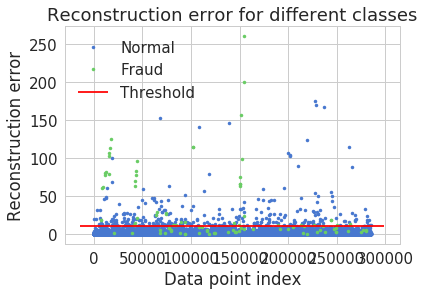

In [42]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

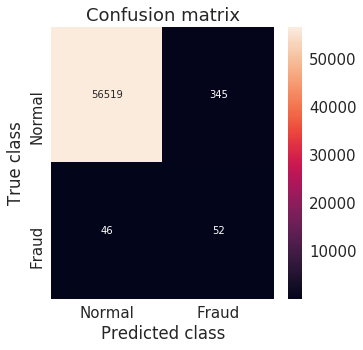

In [43]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()